<a href="https://colab.research.google.com/github/Harshavardhan7299/Keras_Tuner/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Captioning:**
The motive of this project is to predct caption for the image.

**Steps need to be followed:**
1. Data Collection
2. Understand the data
3. Data Cleaning
4. Image Preprocessing
5. Caption Preprocessing
6. Data Preparation using Generator
7. Word Embeddings
8. Model Architecture
9. Training
10. Testing


In [64]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import os
import pickle

from PIL import Image
from numpy import array
from glob import glob
from pickle import dump, load
from time import time

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM, Embedding, Dense,Activation, Flatten,\
                            Reshape,concatenate, Dropout, BatchNormalization,add
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image,sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [19]:
# load doc into memory
def load_doc(filename):
    # Opening file for read only
    file1 = open(filename, 'r')
    # read all text
    text = file1.read()
    # close the file
    file1.close()
    return text

filename = r"/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)

In [20]:
#Loading descriptions with above doc file
def load_descriptions(doc):
    mapping = dict()
    # Process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # Take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # Extract filename from image id
        image_id = image_id.split('.')[0]
        # Convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # Create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # Store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [21]:
# Cleaning above descriptions
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [22]:
# converting those loaded description into vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [23]:
# We are saving descriptions one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file1 = open(filename, 'w')
    file1.write(data)
    file1.close()

save_descriptions(descriptions, '/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Flickr8k_text/descriptions.txt')

In [24]:
# loading  the pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = r'/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Train Dataset: %d' % len(train))

Train Dataset: 6000


In [25]:
# Below path contains all the images
images = r'/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob(images + '*.jpg')

In [26]:
# Below path contains all name of images which is to be used as train data
train_images_file = r'/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Flickr8k_text/Flickr_8k.trainImages.txt'
# Reading the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train image

In [27]:
# Below path contains all name of images which is used to be as test data
test_images_file = r'/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [28]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Flickr8k_text/descriptions.txt', train)
print('Train Descriptions: train=%d' % len(train_descriptions))

Train Descriptions: train=6000


In [29]:
# We're converting our image size 299x299
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [30]:
# Loaded the InceptionV3 model here
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [31]:
# Creating a new model, by removing the last layer(output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [32]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# We're Calling the above funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [34]:
# Save this encoded_train pkl files for training features to the disk
with open("/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [67]:
# We're Calling the above funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 451.90904450416565


In [68]:
# Save the encoded_test pkl file for testing purposes to disk
with open("/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [37]:
#Let's check how many images we're taking for training
train_features = load(open("/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [38]:
# We're creating here a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [39]:
# Considering only those words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
for sent in all_train_captions:
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [40]:
# Here we created two dictionaries
ixtoword = {} #index to word
wordtoix = {} #word to index

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [41]:
vocab_size = len(ixtoword) + 1 #one for appended 0's
vocab_size

1652

In [42]:
# converting a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculating the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [43]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ((array(X1), array(X2)), array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [45]:
# Load Glove vectors(You need to download 'glove.6B.200d.txt')
glove_dir = '/content/drive/MyDrive/Image Captioning/Image_Captioning/glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [46]:
embedding_dim = 200

# Get 200-dimension dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    # If i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [47]:
embedding_matrix.shape

(1652, 200)

In [48]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))

se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [49]:
# Summary of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [50]:
model.layers[2]

In [51]:
# Set the weights for the layers
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [35]:
epochs = 150
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [36]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/Image Captioning/Image_Captioning/model_weights/model_' + str(i) + '.h5')

2000/2000 [==============================] - 184s 92ms/step - loss: 2.2770


In [53]:
# Loading that last saved model from your model_weights folder
model.load_weights('/content/drive/MyDrive/Image Captioning/Image_Captioning/model_weights/model_149.h5')

In [54]:
images = '/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Flicker8k_Dataset/'

In [69]:
# Encoded_test pkl file for testing
with open("/content/drive/MyDrive/Image Captioning/Image_Captioning/data/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [70]:
def imageSearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

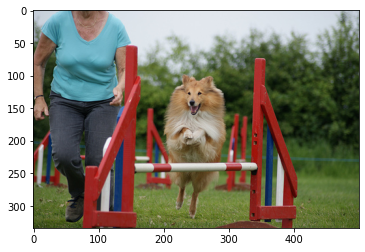

Image with Caption: dog is jumping over hurdle


In [72]:
# Result
pic = list(encoding_test.keys())[0]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image with Caption:",imageSearch(image))

# New Section